In [92]:
import numpy as np 
import pandas as pd
import os
root_path = os.listdir('BirdVsDrone')
print(root_path)

['testing', 'training']


In [95]:
import shutil

root_dir= 'BirdVsDrone'

#os.makedirs(os.path.join(root_dir,"tmp","bird-vs-drone"))

if os.path.exists(root_dir):
    shutil.rmtree(root_dir)

def create_train_test_dirs(root_path):
    os.makedirs(os.path.join(root_dir,"training", "birds"))
    os.makedirs(os.path.join(root_dir,"training","drones"))
    os.makedirs(os.path.join(root_dir,"testing","birds"))
    os.makedirs(os.path.join(root_dir,"testing","drones"))
    
create_train_test_dirs(root_path=root_dir)

In [96]:
import random 

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    file_names = os.listdir(SOURCE)
    random_file_names = random.sample(file_names, len(file_names))
    split_threshold = round(SPLIT_SIZE * len(random_file_names))
    for item in random_file_names[:split_threshold]:
        if os.path.getsize(os.path.join(SOURCE,item)) == 0:
            print(f"{item} is zero length, so ignoring.")
        else:
            shutil.copy(os.path.join(SOURCE,item),TRAINING)
    for item in random_file_names[split_threshold:len(random_file_names)]:
        if os.path.getsize(os.path.join(SOURCE,item)) == 0:
            print(f"{item} is zero length, so ignoring.")
        else:
            shutil.copy(os.path.join(SOURCE,item),TESTING)       

In [97]:
DRONE_SOURCE_DIR = "Bird_Drone_Dataset\BirdVsDrone/Drones/"
BIRD_SOURCE_DIR = "Bird_Drone_Dataset\BirdVsDrone/Birds/"

TRAINING_DIR = 'BirdVsDrone/training'
TESTING_DIR = 'BirdVsDrone/testing'

TRAINING_DRONE_DIR = os.path.join(TRAINING_DIR, "drones/")
TESTING_DRONE_DIR = os.path.join(TESTING_DIR, "drones/")

TRAINING_BIRD_DIR = os.path.join(TRAINING_DIR, "birds/")
TESTING_BIRD_DIR = os.path.join(TESTING_DIR, "birds/")

In [98]:
split_size = 0.9

split_data(DRONE_SOURCE_DIR, TRAINING_DRONE_DIR, TESTING_DRONE_DIR, split_size)
split_data(BIRD_SOURCE_DIR, TRAINING_BIRD_DIR, TESTING_BIRD_DIR, split_size)

In [99]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rescale=1./255)


# Flow training images in batches of 128 using train_datagen generator
train_generator = train_data_gen.flow_from_directory(
    directory = TRAINING_DIR,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
    
validation_generator = validation_datagen.flow_from_directory(directory=TESTING_DIR,
                                                                batch_size=32,
                                                                class_mode='binary',
                                                                target_size=(150, 150))
    


Found 743 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


In [100]:
#print(train_generator.classes)
print(train_generator.class_indices)

print(validation_generator.class_indices)

{'birds': 0, 'drones': 1}
{'birds': 0, 'drones': 1}


In [101]:
#Build a Model
import tensorflow as tf 

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150*150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [102]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)       

In [103]:
#Compile the Model. Using RMSprop Optimizer and Binary Cross Entropy Loss

from tensorflow.keras.optimizers import RMSprop

# Set training parameters
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [104]:
#Train the Model
#Constant for epochs
EPOCHS = 5

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    verbose=1,
    validation_data = validation_generator)

Epoch 1/5
24/24 [==============================] - 48s 2s/step - loss: 0.6695 - accuracy: 0.6043 - val_loss: 0.7115 - val_accuracy: 0.5542
Epoch 2/5
24/24 [==============================] - 47s 2s/step - loss: 0.5793 - accuracy: 0.6999 - val_loss: 0.5168 - val_accuracy: 0.7590
Epoch 3/5
24/24 [==============================] - 50s 2s/step - loss: 0.5088 - accuracy: 0.7564 - val_loss: 0.4863 - val_accuracy: 0.8072
Epoch 4/5
24/24 [==============================] - 52s 2s/step - loss: 0.5010 - accuracy: 0.7645 - val_loss: 0.4670 - val_accuracy: 0.7831
Epoch 5/5
24/24 [==============================] - 55s 2s/step - loss: 0.4444 - accuracy: 0.7981 - val_loss: 0.4636 - val_accuracy: 0.7831


In [105]:
model.save('dronebird.keras')

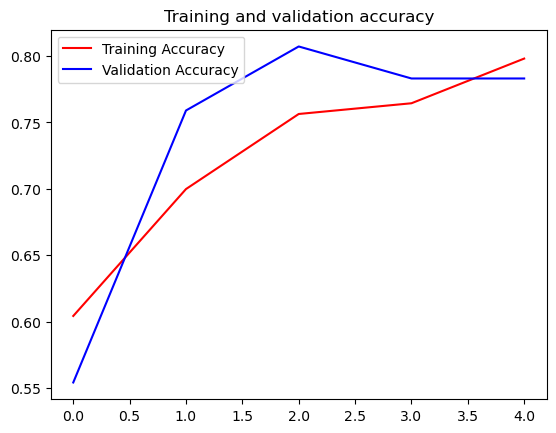

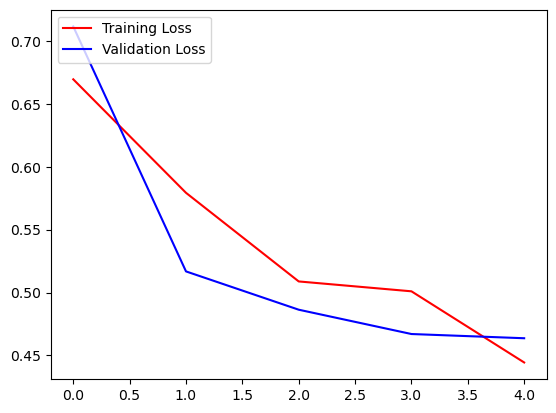

In [106]:
#Plotting Accuracy and Loss
import matplotlib.pyplot as plt


acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend(loc="upper left")
plt.show()
print("")


plt.plot(epochs, loss, 'r', label= "Training Loss")
plt.plot(epochs, val_loss, 'b', label= "Validation Loss")
plt.legend(loc="upper left")
plt.show()


In [107]:
model.save('dronebird.h5')

In [108]:
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import numpy as np


 
model = load_model('dronebird.h5')
 
image = load_img('BirdVsDrone/testing/drones/4.JPEG', target_size=(150,150))
#image = np.argmax(image,axis=-1)
image = np.array(image)
#img = img/ 255.0
image= image.reshape(1,150,150,3)
label = model.predict(image)
class_value = label
print("Predicted Class (0 - Birds , 1- Drones): ",label)

FileNotFoundError: [Errno 2] No such file or directory: 'BirdVsDrone/testing/drones/4.JPEG'

In [109]:
if class_value==0:
    print("Only Birds are identified not drones-don't worry")
else:
    print("Drones are identified in your zone- Alert everyone")
        
    


Drones are identified in your zone- Alert everyone


In [110]:
from time import sleep

sleep(2)


In [111]:
import winsound

In [112]:
from playsound import playsound
from time import sleep
# for playing note.wav file
sleep(2)
if class_value==1:
    #playsound('siren1.wav')
    winsound.PlaySound(r'siren.wav', winsound.SND_ASYNC)
    sleep(10)
    winsound.PlaySound(None, winsound.SND_PURGE)
    winsound.PlaySound(r'voicealert.wav', winsound.SND_ASYNC)
    sleep(20)
    winsound.PlaySound(None, winsound.SND_PURGE)
    
   # playsound('voicealert1.wav')
    
    
    